Import the libraries I need

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

plt.style.use('seaborn')
np.random.seed(seed = 1)

# More Data Prep
Load in the information from my database and remove goalkeepers because the statistics for goalkeepers are totally different. Instead of focusing on things like goals and assists, the statistics for goals are things like saves.

In [2]:
df = pd.read_csv('database.csv', index_col = 0)
df = df[df.position != 'Goalkeeper']


Familiarize ourselves with the data

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1521 entries, 0 to 1608
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   club_name             1521 non-null   object 
 1   player_name           1521 non-null   object 
 2   age                   1521 non-null   int64  
 3   position              1521 non-null   object 
 4   club_involved_name    1521 non-null   object 
 5   fee                   1521 non-null   object 
 6   transfer_movement     1521 non-null   object 
 7   fee_cleaned           1521 non-null   float64
 8   league_name           1521 non-null   object 
 9   year                  1521 non-null   int64  
 10  season                1521 non-null   object 
 11  links                 1521 non-null   object 
 12  Season                1454 non-null   object 
 13  Matches               1454 non-null   float64
 14  Starts                1454 non-null   float64
 15  Minutes              

Many players don't have data on expected statistics. I filled expected goals with the actuals number of goals scored because in general they should be similar numbers. I did the same with assists and expected assists and so on.

In [4]:
df.xG.fillna(df.Goals, inplace = True)
df.npxG.fillna(df.Goals - df.Penalty_Goals, inplace = True)
df.xA.fillna(df.Assists, inplace = True)
df['xG/90'].fillna(df['Goals/90'], inplace = True)
df['xA/90'].fillna(df['Assists/90'], inplace = True)
df['xG+xA/90'].fillna(df['Goals+Assists/90'], inplace = True)
df['npxG/90'].fillna(df['Goals-PKs/90'], inplace = True)
df['npxG+xA/90'].fillna(df['Goals+Assists-PKs/90'], inplace = True)


I dropped the players with no season variable because these are the players who didn't have statistics listed on fbref for the year in question

In [5]:
df.dropna(subset = ['Season'], inplace = True)


I looked at df.info() again to try to find any null values that remained

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1608
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   club_name             1454 non-null   object 
 1   player_name           1454 non-null   object 
 2   age                   1454 non-null   int64  
 3   position              1454 non-null   object 
 4   club_involved_name    1454 non-null   object 
 5   fee                   1454 non-null   object 
 6   transfer_movement     1454 non-null   object 
 7   fee_cleaned           1454 non-null   float64
 8   league_name           1454 non-null   object 
 9   year                  1454 non-null   int64  
 10  season                1454 non-null   object 
 11  links                 1454 non-null   object 
 12  Season                1454 non-null   object 
 13  Matches               1454 non-null   float64
 14  Starts                1454 non-null   float64
 15  Minutes              

I filled the remaining null values with zeros because I think that these null values were fbref's way of saying that no goals or assists were scored by that player that season

In [7]:
df.fillna(0, inplace = True)


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1608
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   club_name             1454 non-null   object 
 1   player_name           1454 non-null   object 
 2   age                   1454 non-null   int64  
 3   position              1454 non-null   object 
 4   club_involved_name    1454 non-null   object 
 5   fee                   1454 non-null   object 
 6   transfer_movement     1454 non-null   object 
 7   fee_cleaned           1454 non-null   float64
 8   league_name           1454 non-null   object 
 9   year                  1454 non-null   int64  
 10  season                1454 non-null   object 
 11  links                 1454 non-null   object 
 12  Season                1454 non-null   object 
 13  Matches               1454 non-null   float64
 14  Starts                1454 non-null   float64
 15  Minutes              

I removed commas from the minutes column as in 1,000 becomes 1000 so I could change it to an integer

In [9]:
df.Minutes = df.Minutes.apply(lambda x: str(x).replace(',', ''))


In [10]:
df.Minutes = df.Minutes.astype('int64')


In [11]:
df.position.value_counts()


Centre-Back           281
Centre-Forward        265
Central Midfield      207
Left Winger           123
Right Winger          117
Right-Back            116
Left-Back             114
Defensive Midfield    111
Attacking Midfield     73
Left Midfield          20
Second Striker         16
Right Midfield         11
Name: position, dtype: int64

I created three new columns is defence, is midfield and is attack, becuase in general attackers are more highly valued than defenders. 

In [12]:
defence_dic = {'Centre-Back': 1, 'Centre-Forward': 0, 'Central Midfield': 0, 'Left Winger': 0, 'Right Winger': 0,
               'Right-Back': 1, 'Left-Back': 1, 'Defensive Midfield': 0, 'Goalkeeper': 1, 'Attacking Midfield': 0,
               'Left Midfield': 0, 'Second Striker': 0, 'Right Midfield': 0}
midfield_dic = {'Centre-Back': 0, 'Centre-Forward': 0, 'Central Midfield': 1, 'Left Winger': 0, 'Right Winger': 0,
                'Right-Back': 0, 'Left-Back': 0, 'Defensive Midfield': 1, 'Goalkeeper': 0, 'Attacking Midfield': 1,
                'Left Midfield': 1, 'Second Striker': 0, 'Right Midfield': 1}
attack_dic = {'Centre-Back': 0, 'Centre-Forward': 1, 'Central Midfield': 0, 'Left Winger': 1, 'Right Winger': 1,
              'Right-Back': 0, 'Left-Back': 0, 'Defensive Midfield': 0, 'Goalkeeper': 0, 'Attacking Midfield': 0,
              'Left Midfield': 0, 'Second Striker': 1, 'Right Midfield': 0}


In [13]:
df['is_defence'] = df.position.replace(defence_dic)
df['is_midfield'] = df.position.replace(midfield_dic)
df['is_attack'] = df.position.replace(attack_dic)

I again explore my data here

Text(0, 0.5, 'Average Transfer Value')

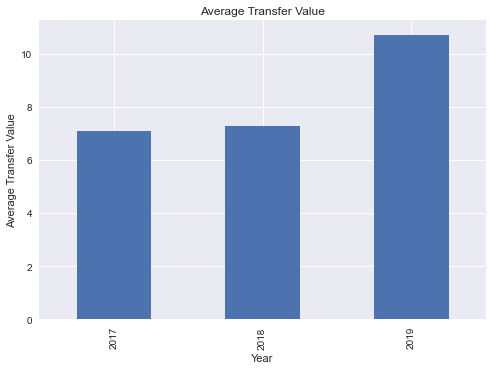

In [14]:
df.groupby('year').fee_cleaned.mean().plot(kind = 'bar', title = 'Average Transfer Value')
plt.xlabel('Year')
plt.ylabel('Average Transfer Value')

Text(0, 0.5, 'Average Transfer Value')

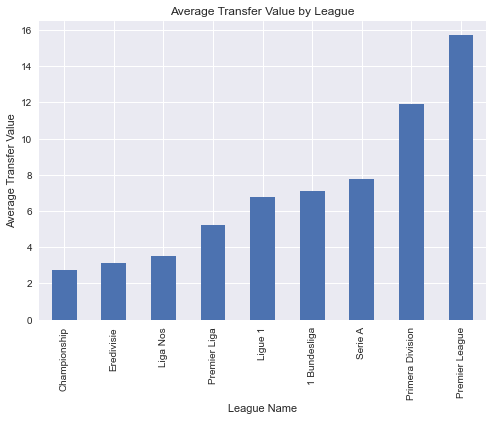

In [15]:
df.groupby('league_name').fee_cleaned.mean().sort_values().plot(kind = 'bar', title = 'Average Transfer Value by League')
plt.xlabel('League Name')
plt.ylabel('Average Transfer Value')

Text(0, 0.5, 'Average Transfer Value')

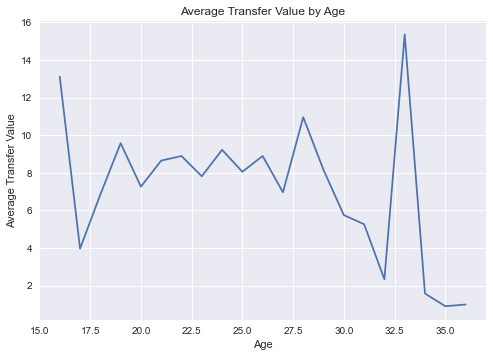

In [16]:
df.groupby('age').fee_cleaned.mean().plot(title = 'Average Transfer Value by Age')
plt.xlabel('Age')
plt.ylabel('Average Transfer Value')

Text(0, 0.5, 'Average Transfer Value')

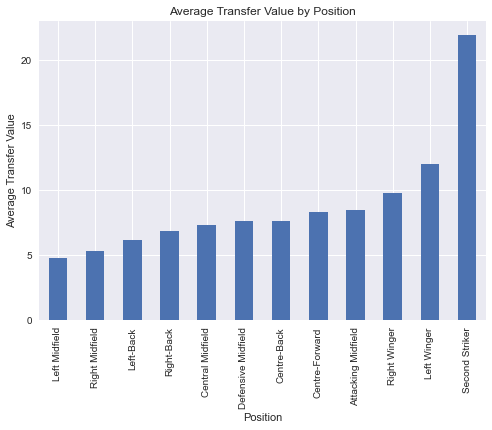

In [17]:
df.groupby('position').fee_cleaned.mean().sort_values().plot(kind = 'bar', title = 'Average Transfer Value by Position')
plt.xlabel('Position')
plt.ylabel('Average Transfer Value')

Text(0.5, 0, 'Transfer Fee')

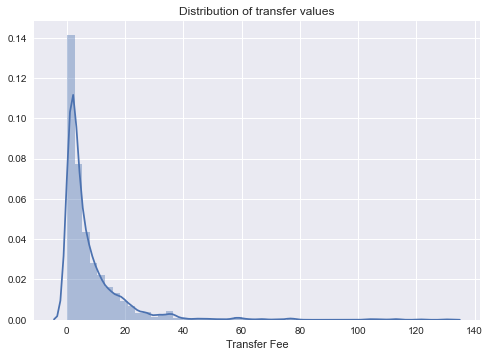

In [18]:
sns.distplot(df.fee_cleaned)
plt.title('Distribution of transfer values')
plt.xlabel('Transfer Fee')

In [19]:
df.fee_cleaned.describe()

count    1454.000000
mean        8.219279
std        12.498243
min         0.045000
25%         1.800000
50%         4.050000
75%         9.900000
max       130.500000
Name: fee_cleaned, dtype: float64

I created a dataframe of features and one of targets

In [20]:
df_features = df[['age','position','Starts','Minutes','Goals','Assists','Penalty_Goals','Penalty_Attempts',
                  'Yellow_Cards','Red_Cards','Goals/90','Assists/90','Goals+Assists/90','Goals-PKs/90',
                  'Goals+Assists-PKs/90','xG','npxG','xA','xG/90','xA/90','xG+xA/90','npxG/90','npxG+xA/90',
                  'is_defence', 'is_midfield', 'is_attack']]
df_target = df.fee_cleaned

I created a dataframe of just my categorical data

In [21]:
df_categoricals = df_features[['position', 'is_defence', 'is_midfield', 'is_attack']]
df_features.columns

Index(['age', 'position', 'Starts', 'Minutes', 'Goals', 'Assists',
       'Penalty_Goals', 'Penalty_Attempts', 'Yellow_Cards', 'Red_Cards',
       'Goals/90', 'Assists/90', 'Goals+Assists/90', 'Goals-PKs/90',
       'Goals+Assists-PKs/90', 'xG', 'npxG', 'xA', 'xG/90', 'xA/90',
       'xG+xA/90', 'npxG/90', 'npxG+xA/90', 'is_defence', 'is_midfield',
       'is_attack'],
      dtype='object')

I used boxplots to look for outliers and than capped values that I felt were problematic

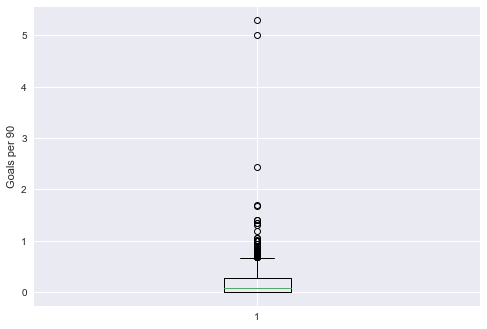

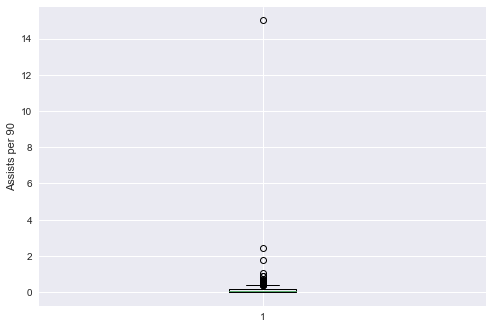

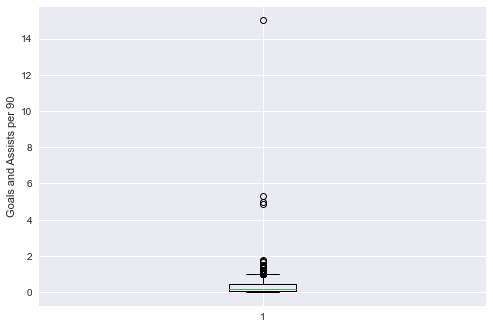

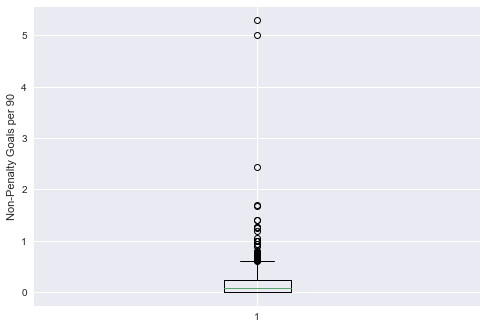

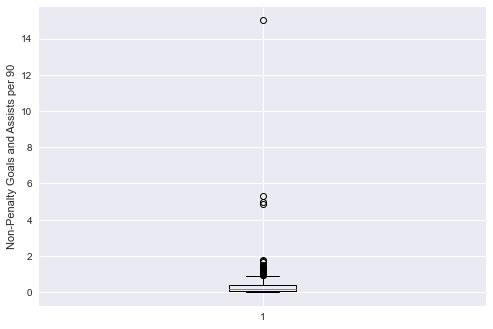

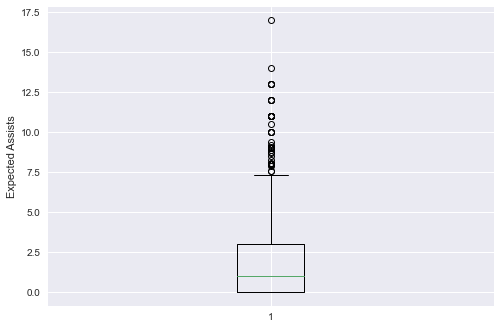

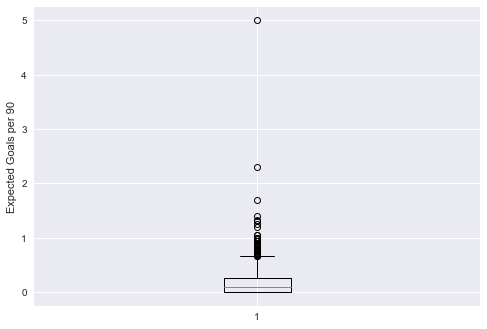

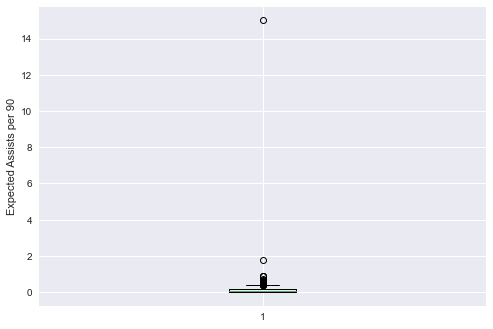

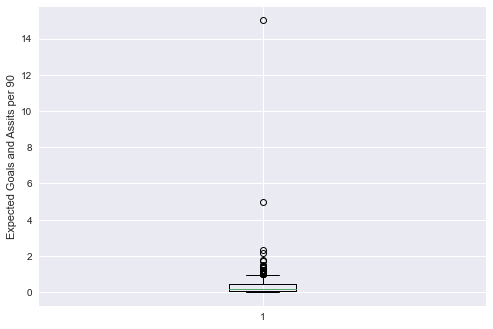

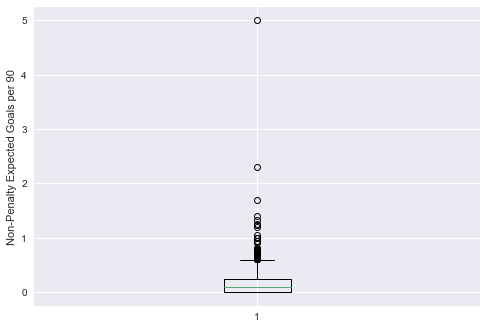

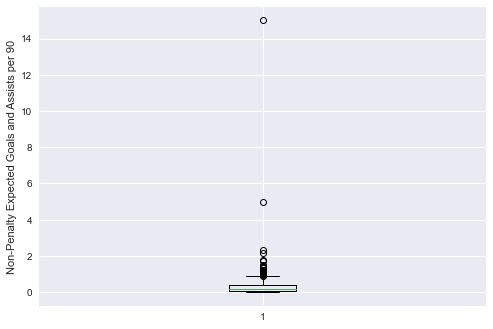

In [22]:
plt.boxplot(df_features['Goals/90'])
plt.ylabel('Goals per 90')
plt.show()
plt.boxplot(df_features['Assists/90'])
plt.ylabel('Assists per 90')
plt.show()
plt.boxplot(df_features['Goals+Assists/90'])
plt.ylabel('Goals and Assists per 90')
plt.show()
plt.boxplot(df_features['Goals-PKs/90'])
plt.ylabel('Non-Penalty Goals per 90')
plt.show()
plt.boxplot(df_features['Goals+Assists-PKs/90'])
plt.ylabel('Non-Penalty Goals and Assists per 90')
plt.show()
plt.boxplot(df_features['xA'])
plt.ylabel('Expected Assists')
plt.show()
plt.boxplot(df_features['xG/90'])
plt.ylabel('Expected Goals per 90')
plt.show()
plt.boxplot(df_features['xA/90'])
plt.ylabel('Expected Assists per 90')
plt.show()
plt.boxplot(df_features['xG+xA/90'])
plt.ylabel('Expected Goals and Assits per 90')
plt.show()
plt.boxplot(df_features['npxG/90'])
plt.ylabel('Non-Penalty Expected Goals per 90')
plt.show()
plt.boxplot(df_features['npxG+xA/90'])
plt.ylabel('Non-Penalty Expected Goals and Assists per 90')
plt.show()

In [23]:
df_features['Goals/90'] = df_features['Goals/90'].apply(lambda x: np.where(x > 2, 2, x))
df_features['Assists/90'] = df_features['Assists/90'].apply(lambda x: np.where(x > 2, 2, x))
df_features['Goals+Assists/90'] = df_features['Goals+Assists/90'].apply(lambda x: np.where(x > 3, 3, x))
df_features['Goals-PKs/90'] = df_features['Goals-PKs/90'].apply(lambda x: np.where(x > 2, 2, x))
df_features['Goals+Assists-PKs/90'] = df_features['Goals+Assists-PKs/90'].apply(lambda x: np.where(x > 3, 3, x))
df_features['xA'] = df_features['xA'].apply(lambda x: np.where(x > 15, 15, x))
df_features['xG/90'] = df_features['xG/90'].apply(lambda x: np.where(x > 2, 2, x))
df_features['xA/90'] = df_features['xA/90'].apply(lambda x: np.where(x > 2, 2, x))
df_features['xG+xA/90'] = df_features['xG+xA/90'].apply(lambda x: np.where(x > 4, 4, x))
df_features['npxG/90'] = df_features['npxG/90'].apply(lambda x: np.where(x > 2, 2, x))
df_features['npxG+xA/90'] = df_features['npxG+xA/90'].apply(lambda x: np.where(x > 3, 3, x))

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

I look at the distributions of all my features

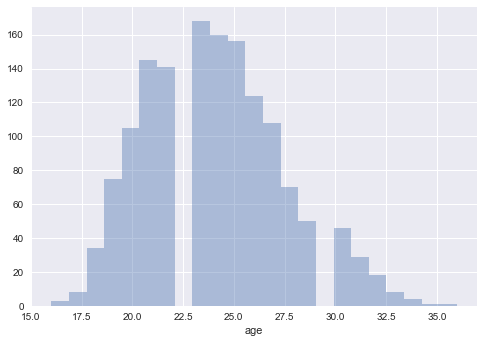

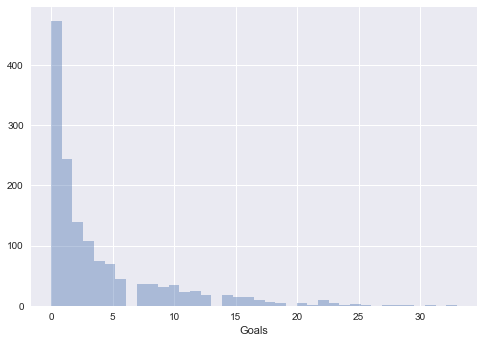

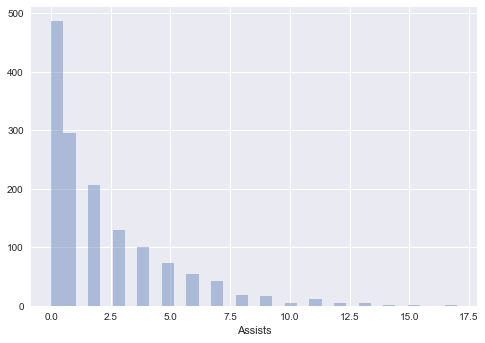

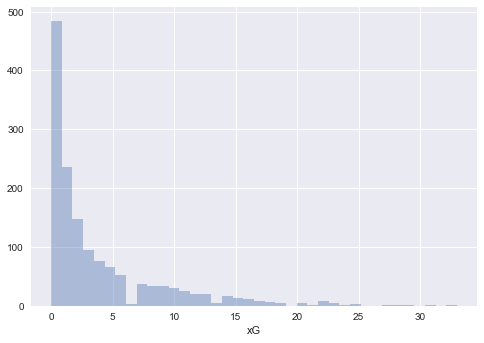

In [24]:
sns.distplot(df_features['age'], kde = False)
plt.show()
sns.distplot(df_features['Goals'], kde = False)
plt.show()
sns.distplot(df_features['Assists'], kde = False)
plt.show()
sns.distplot(df_features['xG'], kde = False)
plt.show()

I plot my features against my target to see if there is a clear pattern for any of them (There isn't)

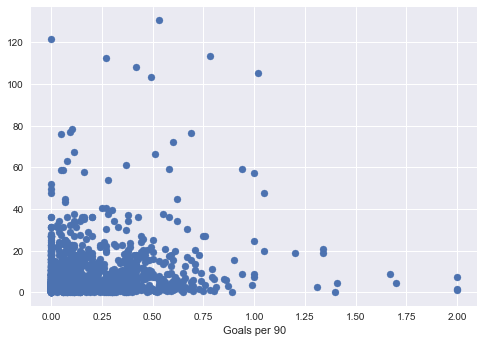

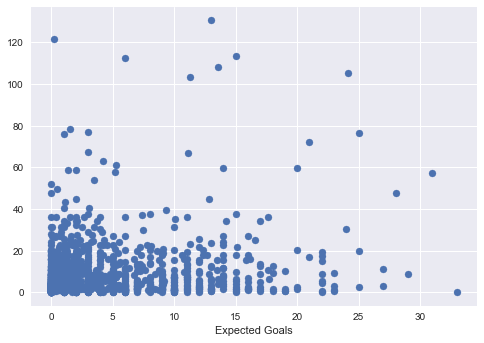

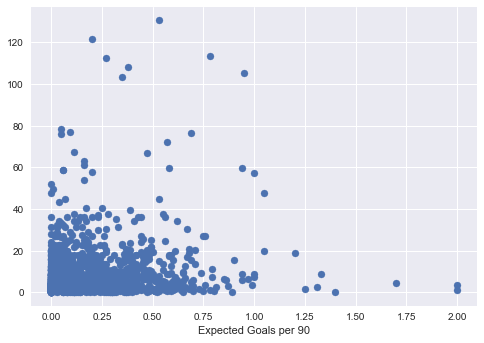

In [25]:
plt.scatter(df_features['Goals/90'], df_target)
plt.xlabel('Goals per 90')
plt.show()
plt.scatter(df_features['xG'], df_target)
plt.xlabel('Expected Goals')
plt.show()
plt.scatter(df_features['xG/90'], df_target)
plt.xlabel('Expected Goals per 90')
plt.show()

I used get dummies on positions

In [26]:
df_dummies = pd.get_dummies(df_features.position)
df_features = pd.concat([df_features, df_dummies], axis = 1)
df_features.drop(['position'], axis = 1, inplace = True)


In [27]:
df_features.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1608
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1454 non-null   int64  
 1   Starts                1454 non-null   float64
 2   Minutes               1454 non-null   int64  
 3   Goals                 1454 non-null   float64
 4   Assists               1454 non-null   float64
 5   Penalty_Goals         1454 non-null   float64
 6   Penalty_Attempts      1454 non-null   float64
 7   Yellow_Cards          1454 non-null   float64
 8   Red_Cards             1454 non-null   float64
 9   Goals/90              1454 non-null   float64
 10  Assists/90            1454 non-null   float64
 11  Goals+Assists/90      1454 non-null   float64
 12  Goals-PKs/90          1454 non-null   float64
 13  Goals+Assists-PKs/90  1454 non-null   float64
 14  xG                    1454 non-null   float64
 15  npxG                 

# Modeling and Evaluation
Perform my train test split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, random_state = 42)


Scaled my data

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Created a dummy regressor to compare my models against

In [30]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
y_train_preds = dummy.predict(X_train)
mean_squared_error(y_train, y_train_preds)


158.15677677430855

In [31]:
y_preds = dummy.predict(X_test)
mean_squared_error(y_test, y_preds)


149.98369916362367

Created a linear regression model

In [32]:
line = LinearRegression(n_jobs = -1)
line.fit(X_train, y_train)
y_train_preds = line.predict(X_train)
mean_squared_error(y_train, y_train_preds)


142.68435426914832

In [33]:
y_preds = line.predict(X_test)
mean_squared_error(y_test, y_preds)


131.24352144016885

Sorted features by coeffecients

In [34]:
sorted(list(zip(line.coef_, df_features.columns)))


[(-56.21940321634334, 'xG'),
 (-17.767702895212466, 'npxG/90'),
 (-17.54719936907125, 'Goals+Assists/90'),
 (-10.651957365421564, 'Goals/90'),
 (-4.9559338413847716, 'Starts'),
 (-4.477631139455966, 'xG+xA/90'),
 (-0.9737462780028965, 'Yellow_Cards'),
 (-0.7397352208819165, 'Left Midfield'),
 (-0.6268355983623553, 'age'),
 (-0.531922583738871, 'Centre-Forward'),
 (-0.39351312789187526, 'Right Midfield'),
 (-0.33580308247863044, 'Left-Back'),
 (-0.22061235957192574, 'Right-Back'),
 (-0.2014082309902449, 'Attacking Midfield'),
 (-0.18101153576599924, 'xA/90'),
 (-0.15897542245618887, 'Central Midfield'),
 (-0.14935718264873116, 'Right Winger'),
 (-0.1267943474773311, 'is_attack'),
 (-0.12484184220299442, 'is_midfield'),
 (-0.06958935242992506, 'Red_Cards'),
 (-0.05365478305564273, 'Penalty_Attempts'),
 (0.2456177996201387, 'is_defence'),
 (0.34373935917920145, 'Left Winger'),
 (0.4116549665592926, 'xA'),
 (0.597054183866855, 'Defensive Midfield'),
 (0.6519113974397006, 'Centre-Back'),
 (

Created a ridge model than used grid search to find optimal parameters

In [35]:
ridge = Ridge()
ridge.fit(X_train, y_train)
y_train_preds = ridge.predict(X_train)
mean_squared_error(y_train, y_train_preds)


143.51255301488732

In [36]:
y_preds = ridge.predict(X_test)
mean_squared_error(y_test, y_preds)


131.5378701871753

In [37]:
param_grid = {'alpha': [.01,.1,.5,1,5,10,15, 20, 25, 30, 100, 1000, 1500, 2500]}
ridge_CV = GridSearchCV(ridge, param_grid, scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 1)
ridge_CV.fit(X_train, y_train)
print(ridge_CV.best_score_)
print(ridge_CV.best_params_)
y_preds = ridge_CV.predict(X_test)
mean_squared_error(y_test, y_preds)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-12.14756156929301
{'alpha': 1000}


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.5s finished


135.0554309351698

Plotted Coeffecients

In [38]:
sorted(list(zip(ridge.coef_, df_features.columns)))


[(-12.290572767573387, 'xG'),
 (-3.547472730272181, 'Starts'),
 (-2.5371851801728393, 'Goals+Assists/90'),
 (-2.3901523470822963, 'xG+xA/90'),
 (-1.1753439356440365, 'Penalty_Attempts'),
 (-0.9333628605569633, 'Yellow_Cards'),
 (-0.8020203027514491, 'Goals/90'),
 (-0.742306758867302, 'Left Midfield'),
 (-0.6432094674525344, 'age'),
 (-0.48186052447345706, 'Centre-Forward'),
 (-0.3943824762050621, 'Right Midfield'),
 (-0.33958101402236923, 'Left-Back'),
 (-0.2361140945299251, 'Attacking Midfield'),
 (-0.21252790803967164, 'Right-Back'),
 (-0.19069456025870604, 'Right Winger'),
 (-0.16888505106331664, 'xA'),
 (-0.16045005538051063, 'Central Midfield'),
 (-0.14625383766148187, 'is_midfield'),
 (-0.09944187953594681, 'is_attack'),
 (-0.06406091586540656, 'Red_Cards'),
 (0.23879121358907016, 'is_defence'),
 (0.34305985828229313, 'Left Winger'),
 (0.47226025730042637, 'npxG/90'),
 (0.5940487212510209, 'Defensive Midfield'),
 (0.6030785488911407, 'xA/90'),
 (0.640815168709834, 'Centre-Back'),

Created Lasso model than tuned hyper parameters with grid search than looked at coefficients

In [39]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_train_preds = lasso.predict(X_train)
mean_squared_error(y_train, y_train_preds)


150.96405191159712

In [40]:
y_preds = lasso.predict(X_test)
mean_squared_error(y_test, y_preds)


140.30379305337658

In [41]:
param_grid = {'alpha': [.01,.1,.5,1,5,10]}
lasso_CV = GridSearchCV(lasso, param_grid, scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 1)
lasso_CV.fit(X_train, y_train)
print(lasso_CV.best_score_)
print(lasso_CV.best_params_)
y_preds = lasso_CV.predict(X_test)
mean_squared_error(y_test, y_preds)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
-12.169630941838868
{'alpha': 0.5}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


136.46720686715707

In [42]:
sorted(list(zip(lasso.coef_, df_features.columns)))


[(0.0, 'Assists/90'),
 (-0.0, 'Attacking Midfield'),
 (-0.0, 'Central Midfield'),
 (0.0, 'Centre-Back'),
 (-0.0, 'Centre-Forward'),
 (0.0, 'Defensive Midfield'),
 (0.0, 'Goals+Assists-PKs/90'),
 (0.0, 'Goals+Assists/90'),
 (0.0, 'Goals-PKs/90'),
 (0.0, 'Goals/90'),
 (-0.0, 'Left Midfield'),
 (0.0, 'Left Winger'),
 (-0.0, 'Left-Back'),
 (0.0, 'Minutes'),
 (0.0, 'Penalty_Attempts'),
 (0.0, 'Penalty_Goals'),
 (-0.0, 'Red_Cards'),
 (-0.0, 'Right Midfield'),
 (0.0, 'Right Winger'),
 (-0.0, 'Right-Back'),
 (0.0, 'Second Striker'),
 (0.0, 'Starts'),
 (-0.0, 'Yellow_Cards'),
 (-0.0, 'age'),
 (0.0, 'is_attack'),
 (-0.0, 'is_defence'),
 (-0.0, 'is_midfield'),
 (0.0, 'npxG'),
 (0.0, 'npxG+xA/90'),
 (0.0, 'npxG/90'),
 (0.0, 'xA'),
 (0.0, 'xA/90'),
 (0.0, 'xG'),
 (0.0, 'xG+xA/90'),
 (0.0, 'xG/90'),
 (0.7400692678152119, 'Goals'),
 (1.2762662845964627, 'Assists')]

Did the same thing with support vector regressor

In [43]:
svr = SVR()
svr.fit(X_train, y_train)
y_train_preds = svr.predict(X_train)
mean_squared_error(y_train, y_train_preds)


164.958054903222

In [44]:
y_preds = svr.predict(X_test)
mean_squared_error(y_test, y_preds)


158.27376011007516

In [45]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
             'degree': [.5,1,2,3], 'C': [1,5,10,25,50], 'epsilon': [.1, .5, 1, 5, 10]}
svr_CV = GridSearchCV(svr, param_grid, scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 1)
svr_CV.fit(X_train, y_train)
print(svr_CV.best_score_)
print(svr_CV.best_params_)
y_preds = svr_CV.predict(X_test)
mean_squared_error(y_test, y_preds)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1423 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   43.0s


-12.192840629208913
{'C': 10, 'degree': 0.5, 'epsilon': 5, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   56.7s finished


142.16443119520596

Created than tuned a decision tree regressor

In [46]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_train_preds = tree.predict(X_train)
mean_squared_error(y_train, y_train_preds)


0.32988618623853205

In [47]:
y_preds = tree.predict(X_test)
mean_squared_error(y_test, y_preds)


263.38415133035716

In [48]:
param_grid = {'max_depth': [None, 1, 2, 5, 10], 'min_samples_split': [2,4,6,8,10],
              'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}
tree_CV = GridSearchCV(tree, param_grid, scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 1)
tree_CV.fit(X_train, y_train)
print(tree_CV.best_score_)
print(tree_CV.best_params_)
y_preds = tree_CV.predict(X_test)
mean_squared_error(y_test, y_preds)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s


-12.214885057595277
{'max_depth': 2, 'min_samples_leaf': 7, 'min_samples_split': 2}


[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:    1.5s finished


153.38535002126525

Created and tuned a random forest model. This one performed best.

In [49]:
rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)
y_train_preds = rf.predict(X_train)
mean_squared_error(y_train, y_train_preds)


23.770938014808145

In [50]:
y_preds = rf.predict(X_test)
mean_squared_error(y_test, y_preds)


136.78208289603378

In [51]:
param_grid = {'n_estimators': [5, 10, 25,50,100,500], 'max_depth': [None, 1, 2, 3, 4, 5, 10],
              'min_samples_split': [2,4,6,8,10,15,20]}
rf_CV = GridSearchCV(rf, param_grid, scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 1)
rf_CV.fit(X_train, y_train)
print(rf_CV.best_score_)
print(rf_CV.best_params_)
y_preds = rf_CV.predict(X_test)
mean_squared_error(y_test, y_preds)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed:  2.4min finished


-12.134814863644525
{'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 5}


128.60827288806308

Text(0, 0.5, 'Residuals')

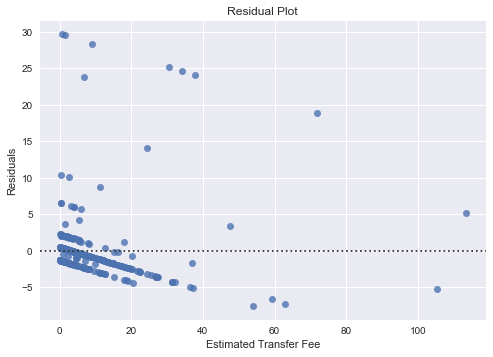

In [62]:
sns.residplot(y_test, y_preds)
plt.title('Residual Plot')
plt.xlabel('Estimated Transfer Fee')
plt.ylabel('Residuals')

Examine feature importances

In [53]:
sorted(zip(rf_CV.best_estimator_.feature_importances_, df_features.columns))

[(0.0, 'Assists/90'),
 (0.0, 'Attacking Midfield'),
 (0.0, 'Central Midfield'),
 (0.0, 'Centre-Back'),
 (0.0, 'Centre-Forward'),
 (0.0, 'Defensive Midfield'),
 (0.0, 'Goals+Assists-PKs/90'),
 (0.0, 'Goals+Assists/90'),
 (0.0, 'Goals-PKs/90'),
 (0.0, 'Left Midfield'),
 (0.0, 'Left Winger'),
 (0.0, 'Left-Back'),
 (0.0, 'Penalty_Attempts'),
 (0.0, 'Penalty_Goals'),
 (0.0, 'Red_Cards'),
 (0.0, 'Right Midfield'),
 (0.0, 'Right Winger'),
 (0.0, 'Right-Back'),
 (0.0, 'Starts'),
 (0.0, 'Yellow_Cards'),
 (0.0, 'age'),
 (0.0, 'is_attack'),
 (0.0, 'is_defence'),
 (0.0, 'is_midfield'),
 (0.0, 'xA/90'),
 (0.0, 'xG'),
 (0.0, 'xG+xA/90'),
 (0.0, 'xG/90'),
 (0.03910623697454691, 'npxG/90'),
 (0.040981692656596375, 'npxG'),
 (0.05048816920466362, 'npxG+xA/90'),
 (0.05924256048431698, 'xA'),
 (0.0904528051918005, 'Goals'),
 (0.1082312950410385, 'Minutes'),
 (0.12331745340822188, 'Second Striker'),
 (0.20308727017309325, 'Goals/90'),
 (0.28509251686572185, 'Assists')]

Lastly I used an xgboost model and tuned hyperparametes.

In [54]:
xg = xgb.XGBRegressor(n_jobs = -1, objective = 'reg:squarederror', eval_metric = 'rmse')
xg.fit(X_train, y_train)
y_train_preds = xg.predict(X_train)
mean_squared_error(y_train, y_train_preds)


1.476298015111357

In [55]:
y_preds = xg.predict(X_test)
mean_squared_error(y_test, y_preds)


162.03224820607335

In [56]:
sorted(zip(xg.feature_importances_, df_features.columns))


[(0.0044081816, 'Left-Back'),
 (0.004467047, 'Penalty_Attempts'),
 (0.0047162347, 'Central Midfield'),
 (0.0072989124, 'Defensive Midfield'),
 (0.00811699, 'Right Winger'),
 (0.00859931, 'Assists/90'),
 (0.009251139, 'Centre-Back'),
 (0.009873895, 'Right-Back'),
 (0.01032367, 'is_defence'),
 (0.010406257, 'xA/90'),
 (0.010441739, 'Red_Cards'),
 (0.012015592, 'Right Midfield'),
 (0.012033916, 'Left Midfield'),
 (0.012538184, 'Starts'),
 (0.012557619, 'age'),
 (0.013130587, 'Centre-Forward'),
 (0.014046554, 'is_midfield'),
 (0.015302745, 'Minutes'),
 (0.015870897, 'Goals-PKs/90'),
 (0.016197294, 'Attacking Midfield'),
 (0.018368926, 'Yellow_Cards'),
 (0.019278776, 'Goals/90'),
 (0.020559067, 'xG/90'),
 (0.021760605, 'npxG'),
 (0.025872208, 'Goals+Assists-PKs/90'),
 (0.026402956, 'npxG+xA/90'),
 (0.033240046, 'Goals'),
 (0.033254035, 'xA'),
 (0.03825296, 'xG+xA/90'),
 (0.039958697, 'xG'),
 (0.044858325, 'Goals+Assists/90'),
 (0.055941634, 'npxG/90'),
 (0.058066867, 'Penalty_Goals'),
 (0.0

In [57]:
param_grid = {'eta': [1e-100, 1e-50, 1e-20, 1e-10,.000000001, .00000001],
              'max_depth': [1,2,3],
              'min_child_weight': [15,20, 25, 30, 50, 75,  100]}
xg_CV = GridSearchCV(xg, param_grid, scoring = 'neg_root_mean_squared_error', n_jobs = -1, verbose = 1)
xg_CV.fit(X_train, y_train)
print(xg_CV.best_score_)
print(xg_CV.best_params_)
y_preds = xg_CV.predict(X_test)
mean_squared_error(y_test, y_preds)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s


-12.041900684138943
{'eta': 1e-20, 'max_depth': 1, 'min_child_weight': 50}


[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    9.9s finished


130.42788322745764